In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random

## Parámetros

In [2]:
# Escenario 1
folder = './data/test1/' # Carpeta con los datos
info_CA = folder + 'nuevo_info_acopios.xlsx' # Datos de centros de acopio 
info_costTransp = folder + 'costoTransporteCAi.xlsx' # Matriz de costos de transporte entre CAs 
info_timeTransp = folder + 'tiempoTransporteCAi.xlsx' # Matriz de tiempos de transporte entre CAs
demanda = 60 # Demanda del cliente
ctiempo = 100 # Costo por unidad de tiempo

feromona_inicial = 1/100
alpha = 1
beta = 1
rho = 0.999
Q = 1000
tam_hormiguero = 30
max_iter = 300

In [3]:
class CA:  # Centros de acopio
    def __init__(self, idCA, cant_stock, cant_pot):
        self.idCA = idCA
        self.en_Stock = cant_stock  # True: disponible en stock, si no, es capacidad potencial
        self.potencial = cant_pot

Modelo de hormiga

$$
    p^{k}_{ij}(t) = 
        \frac{ [\tau_{ij}(t)]^\alpha \cdot [\eta_{ij}(t)]^\beta }{ \sum_{l \in J_i^k}[\tau_{ij}(t)]^\alpha \cdot [\eta_{il}]^\beta }
$$

In [4]:
class Ant:
    def __init__(self, demanda, CAs_list, i, Q):
        self.ant_id = i
        self.sol_CAs = []
        self.cheese_cant = 0
        self.available_CAs = copy.deepcopy(CAs_list)
        self.demanda = demanda
        self.CAP = 0
        self.idx_CAP = 0
        self.eta_CAP = 0
        self.costo_total = 0
        self.pheromone_delta = np.zeros(len(self.available_CAs))
        self.Q = Q
        self.tao_ini = Q/Q
        
    
    def select_CAP(self, df_infoCA, costo_tiempo, alpha, beta):
        deltica = 0.00001  # Para evitar división por 0
        tao = self.tao_ini  # Asumiendo feromona constante hasta el momento
        temp = np.zeros(len(self.available_CAs))
        denominador = 0
        i = 0
        
        for CA in self.available_CAs:
            if CA.en_Stock > 0:
                # Cantidad para asignar
                to_take = min(CA.en_Stock, self.demanda)
                eta = to_take * df_infoCA.loc[CA.idCA, 'Precio'] + df_infoCA.loc[CA.idCA, 'Ctransp'] + df_infoCA.loc[CA.idCA, 'TiempoTransp'] * costo_tiempo
                
                eta_beta = eta ** beta
                tao_alpha = tao ** alpha
                
                temp[i] = (eta_beta * tao_alpha)
                denominador += temp[i]
                
            i += 1
            
        probabilities = np.divide(temp, denominador + deltica)
        
        ids = 0
        rand = random.random()
        
        for i, prob in enumerate(probabilities):
            rand -= prob
            if rand <= 0:
                ids = i
                break
                
        self.CAP = self.available_CAs[ids].idCA
        self.cheese_cant = min(self.available_CAs[ids].en_Stock, self.demanda)
        self.available_CAs[ids].en_Stock = self.available_CAs[ids].en_Stock - self.cheese_cant
        self.idx_CAP = ids
        self.sol_CAs.append((self.CAP, self.cheese_cant, 'Stock'))
        self.eta_CAP = self.cheese_cant * df_infoCA.loc[self.CAP, 'Precio'] + df_infoCA.loc[self.CAP, 'Ctransp'] + df_infoCA.loc[self.CAP, 'TiempoTransp'] * costo_tiempo
        self.costo_total = self.eta_CAP
        
        
    def select_next_CA(self, df_infoCA, df_cTransp, df_tTransp, costo_tiempo, alpha, beta, pheromone):
        prob_temp = np.zeros(len(self.available_CAs))
        idx = 0
        denominador = 0
        
        for CA in self.available_CAs:
            if CA.en_Stock + CA.potencial > 0:
                if CA.en_Stock > 0:
                    to_take = min(CA.en_Stock, self.demanda - self.cheese_cant)
                    eta = to_take * df_infoCA.loc[CA.idCA, 'Precio'] + df_cTransp.loc[self.CAP, CA.idCA] + df_tTransp.loc[self.CAP, CA.idCA] * costo_tiempo
                    
                elif CA.potencial > 0:
                    to_take = min(CA.potencial, self.demanda - self.cheese_cant)
                    eta = to_take * df_infoCA.loc[CA.idCA, 'Precio'] + df_infoCA.loc[CA.idCA, 'TiempoAlistam'] * costo_tiempo
                        
                eta_beta = (eta + self.costo_total) ** beta
                tao_alpha = pheromone[self.idx_CAP][idx] ** alpha
                prob_temp[idx] = (eta_beta * tao_alpha)
                denominador += prob_temp[idx]
                
            idx += 1
        
        if denominador == 0: return -1
        probabilities = np.divide(prob_temp, denominador)
        
        ids = 0
        rand = random.random()
        for i, prob in enumerate(probabilities):
            rand -= prob
            if rand <= 0:
                ids = i
                break
                
        if self.available_CAs[ids].en_Stock + self.available_CAs[ids].potencial == 0:
            print('No hay queso disponible para asignar')
            return -1
        
        taken = 0
        if self.available_CAs[ids].en_Stock > 0:
            tipo = 'Stock'
            taken = min(self.available_CAs[ids].en_Stock, self.demanda - self.cheese_cant)
            self.cheese_cant += taken
            CA = self.available_CAs[ids].idCA
            self.available_CAs[ids].en_Stock = self.available_CAs[ids].en_Stock - taken
            costo = taken * df_infoCA.loc[CA, 'Precio'] + df_cTransp.loc[self.CAP, CA] + df_tTransp.loc[self.CAP, CA] * costo_tiempo
            
        elif self.available_CAs[ids].potencial > 0: 
            tipo = 'Potencial'
            taken = min(self.available_CAs[ids].potencial, self.demanda - self.cheese_cant)
            self.cheese_cant += taken
            CA = self.available_CAs[ids].idCA
            self.available_CAs[ids].potencial = self.available_CAs[ids].potencial - taken
            costo = taken * df_infoCA.loc[CA, 'Precio'] + df_infoCA.loc[CA, 'TiempoAlistam'] * costo_tiempo
            
        if taken > 0:
            self.costo_total += costo
            self.sol_CAs.append((CA, taken, tipo))
            self.pheromone_delta[ids] += Q / costo
        return ids


    def complet_order(self, df_infoCA, df_cTransp, df_tTransp, costo_tiempo, beta, alpha, pheromone):
        while self.cheese_cant < self.demanda:
            self.select_next_CA(df_infoCA, df_cTransp, df_tTransp, costo_tiempo, alpha, beta, pheromone)


    def show_availableCAs(self):
        for CA in self.available_CAs:
            print(CA.idCA, CA.cantidad, CA.en_Stock)  

In [5]:
class ACO_cheese:
    def __init__(self, demanda_g, colony_size, feromona_inicial, alpha, beta, rho, Q):
        self.df_infoCA = 0
        self.df_cTransp = 0
        self.df_tTransp = 0
        self.demanda_g = demanda_g
        self.N_CA = 0
        self.costo_tiempo = 0
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.colony_size = colony_size
        self.disponibles = []
        self.pheromone = []
        self.feromona_inicial = feromona_inicial
        
        
    def read_infoProblem(self, info_CAs, info_costTransporte, info_tiempoTransporte, costo_tiempo):
        self.df_infoCA = pd.read_excel(info_CAs)
        self.df_infoCA.set_index(self.df_infoCA.columns[0], inplace=True)
        self.N_CA = len(self.df_infoCA)
    
        self.df_cTransp = pd.read_excel(info_costTransporte)
        self.df_cTransp.set_index(self.df_cTransp.columns[0], inplace=True)
        
        self.df_tTransp = pd.read_excel(info_tiempoTransporte)
        self.df_tTransp.set_index(self.df_tTransp.columns[0], inplace=True)
        
        self.crea_lista_disponibles()
        self.costo_tiempo = costo_tiempo
    
    def crea_lista_disponibles(self):
        df_infoCA = self.df_infoCA
        
        for index, r in df_infoCA.iterrows():
            oferta1 = CA(index, df_infoCA.loc[index, 'Stock'], df_infoCA.loc[index, 'Ppotencial'])
            self.disponibles.append(oferta1)
        self.pheromone = [[self.feromona_inicial for _ in range(self.N_CA)] for _ in range(self.N_CA)]
        
    def update_pheromone(self, colony):
        for i in range(self.N_CA):
            for j in range(self.N_CA):
                self.pheromone[i][j] *= self.rho
                
        for ant in colony:
            i = ant.idx_CAP
            for j in range(self.N_CA):
                self.pheromone[i][j] += ant.pheromone_delta[j]
                
    def ACO_run(self, max_iter):
        N_Ants = self.colony_size
        best_costo = float('inf')
        best_sol = []
        progress = []
        
        for iteracion in range(max_iter):
            colony = []
            
            for i in range(N_Ants):
                a = Ant(self.demanda_g, self.disponibles, i, self.Q)
                a.select_CAP(self.df_infoCA, self.costo_tiempo, 1, 1)
                a.complet_order(self.df_infoCA, self.df_cTransp, self.df_tTransp, self.costo_tiempo, self.alpha, self.beta, self.pheromone)
                
                colony.append(a)
                
                if a.costo_total < best_costo:
                    best_costo = a.costo_total
                    best_sol = a.sol_CAs
                    
            self.update_pheromone(colony)
            progress.append(best_costo)
            
        return progress, best_sol, best_costo

In [6]:
def plot_convergence(fitness_list):
    plt.plot([i for i in range(len(fitness_list))], fitness_list)
    plt.ylabel('Fitness')
    plt.xlabel('Iteracion')
    plt.show()

In [7]:
def show_bestResult(best_solution, best_costo):
    print('La mejor solución encontrada: ')
    print(best_solution)
    print('Con costo total: ')
    print(best_costo)

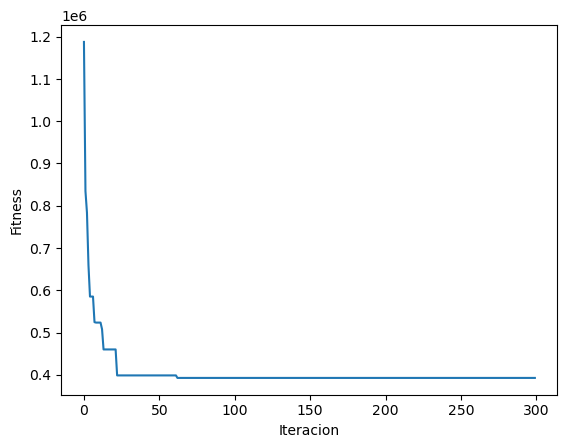

La mejor solución encontrada: 
[('CA2', 12, 'Stock'), ('CA1', 10, 'Stock'), ('CA1', 0.5, 'Potencial'), ('CA4', 8, 'Stock'), ('CA8', 2, 'Stock'), ('CA2', 0.625, 'Potencial'), ('CA8', 12.5, 'Potencial'), ('CA4', 13.0, 'Potencial'), ('CA7', 1.375, 'Stock')]
Con costo total: 
392608.0


In [8]:
cheese_order = ACO_cheese(demanda, tam_hormiguero, feromona_inicial, alpha, beta, rho, Q)
cheese_order.read_infoProblem(info_CA, info_costTransp, info_timeTransp, ctiempo)

progress, best_sol, best_costo = cheese_order.ACO_run(max_iter)
plot_convergence(progress)
show_bestResult(best_sol, best_costo)